In [1]:
#Import Libraries
import torchvision
import torchvision.transforms as transforms
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable


In [2]:
#Loade Fashio MNIST Dataset
trainset = torchvision.datasets.FashionMNIST('MNIST/', download = True, train = True, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST('MNIST/', download = True, train = False, transform = transforms.ToTensor())
# Create Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = True)

In [3]:
# Create CNN Model
class CNNmodel(nn.Module):
    
    def __init__(self,activation_func,dp):
        super(CNNmodel, self).__init__()
        self.activation_func=activation_func
        self.dp=dp
        self.conv1=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.layer1 = nn.Sequential(
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.layer2 = nn.Sequential(       
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.fc1 = nn.Linear(in_features=64*4*4, out_features=1024)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        torch.nn.init.xavier_uniform(self.fc3.weight)
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.conv2(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out=self.activation_func(out)
        out = self.fc2(out)
        out=self.activation_func(out)
        if self.dp is not False:
          out=nn.Dropout(self.dp)(out)
        out = self.fc3(out)
        
        return out

In [4]:
def run_model(activation_func,dp,lr,epochs):
  torch.cuda.empty_cache() #clear gpu ram
  model=CNNmodel(activation_func=activation_func,dp=dp) #create model
  print(model)
  num_epochs = epochs #number od epochs
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  error = nn.CrossEntropyLoss() #create loss function
  learning_rate = lr #learning rate
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #SGD optimizer
  # Lists for visualization of loss and accuracy 
  train_losses = []
  test_losses=[]

  train_accuracy_list = []
  test_accuracy_list = []
  # Lists for knowing classwise accuracy
  predictions_list = {}
  labels_list = {}

  for epoch in range(num_epochs): #start training 
      train_loss=0
      train_total = 0
      train_correct = 0
      count=0
      train_loss_iter=0
      for images, labels in trainloader:

          # Transfering images and labels to GPU if available
          images, labels = images.to(device), labels.to(device) #load each image
      
          train = Variable(images.view(32, 1, 28, 28)) 
          labels = Variable(labels)
          
          # Forward pass 
          outputs = model(train) #give the image to model and get the results

          predictions = torch.max(outputs, 1)[1].to(device) #get the predictions
          train_correct += (predictions == labels).sum() #compute the correct predicted images
          train_total += len(labels)

          loss = error(outputs, labels) #compute the loss
          train_loss+=loss.data
          train_loss_iter+=1
          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad() 
          
          #Propagating the error backward
          loss.backward()
          
          # Optimizing the parameters
          optimizer.step() 
          count+=1
          #if count%1000==0:
            #print('{} Iterations passed'.format(count+1))
      train_accuracy_list.append(train_correct * 100 / train_total)
      train_losses.append(train_loss/train_loss_iter)
      print('{} epoch passed: Train Accuracy: {}, Train Loss: {}'.format(epoch+1,train_correct * 100 / train_total,train_loss/train_loss_iter))
      test_loss_iter=0
      test_loss=0
      test_total = 0
      test_correct = 0
      # Testing the model
      for images, labels in testloader:
          images, labels = images.to(device), labels.to(device)
          labels_list[epoch+1]=labels
          if images.shape!=(32,1,28,28):
            test = Variable(images.view(16, 1, 28, 28))
          else:
            test = Variable(images.view(32, 1, 28, 28))
          outputs = model(test)
          test_error=error(outputs, labels)
          test_loss += test_error.data
          test_loss_iter+=1
          predictions = torch.max(outputs, 1)[1].to(device)
          predictions_list[epoch+1]=predictions
          test_correct += (predictions == labels).sum()      
          test_total += len(labels)

      test_losses.append(test_loss/test_loss_iter)
      test_accuracy_list.append(test_correct * 100 / test_total)
      print('Test Accuracy: {}, Test Loss: {}'.format(test_correct * 100 / test_total,test_loss/test_loss_iter))
  print('Best Test Accuarcy: ',max(test_accuracy_list))
  return(train_accuracy_list,train_losses,test_accuracy_list,test_losses)

In [5]:
def plot_model(train_accuracy_list,train_losses,test_accuracy_list,test_losses,model_name):
  !mkdir 'plots'
  try:
    os.mkdir('plots/{}'.format(model_name))
  except:
    pass
  plt.figure(1)
  plt.plot([i+1 for i in range(len(train_losses))] ,train_losses)
  plt.xlabel("No. of Epochs")
  plt.ylabel("Train Loss")
  plt.title("{}Train Loss per epoch".format(model_name))
  plt.grid()
  plt.savefig("plots/{}/{}Train Loss per epoch.jpg".format(model_name,model_name))
  plt.show()
  plt.figure(2)
  plt.plot([i+1 for i in range(len(train_accuracy_list))] ,train_accuracy_list)
  plt.xlabel("No. of Epochs")
  plt.ylabel("Train Accuracy")
  plt.title("{}Train Accuracy per epoch".format(model_name))
  plt.grid()
  plt.savefig("plots/{}/{}Train Accuracy per epoch.jpg".format(model_name,model_name))
  plt.show()
  plt.figure(3)
  plt.plot([i+1 for i in range(len(test_accuracy_list))] ,test_accuracy_list)
  plt.xlabel("No. of Epochs")
  plt.ylabel("Test Accuracy")
  plt.title("{}Test Accuracy per epoch".format(model_name))
  plt.grid()
  plt.savefig("plots/{}/{}Test Accuracy per epoch.jpg".format(model_name,model_name))
  plt.show()
  plt.figure(4)
  plt.plot([i+1 for i in range(len(test_losses))] ,test_losses)
  plt.xlabel("No. of Epochs")
  plt.ylabel("Test Loss")
  plt.title("{}Test Loss per epoch".format(model_name))
  plt.grid()
  plt.savefig("plots/{}/{}Test Loss per epoch.jpg".format(model_name,model_name))
  plt.show()


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


1 epoch passed: Train Accuracy: 80.6866683959961, Train Loss: 0.5165040493011475
Test Accuracy: 86.5999984741211, Test Loss: 0.36965441703796387
2 epoch passed: Train Accuracy: 87.96333312988281, Train Loss: 0.3228355646133423
Test Accuracy: 87.9000015258789, Test Loss: 0.3254238963127136
3 epoch passed: Train Accuracy: 89.82333374023438, Train Loss: 0.27399274706840515
Test Accuracy: 88.36000061035156, Test Loss: 0.3188868463039398
4 epoch passed: Train Accuracy: 90.77833557128906, Train Loss: 0.24600139260292053
Test Accuracy: 89.79000091552734, Test Loss: 0.2794840931892395
5 epoch passed: Train Accuracy: 91.66166687011719, Train Loss: 0.222223699092865
Test Accuracy: 89.68000030517578, Test Loss: 0.2936570346355438
6 epoch passed: Train Accuracy: 92.35333251953125, Train Loss: 0.20131078362464905
Test Accuracy: 90.56999969482422, Test Loss: 0.2528570890426636
7 epoch passed: Train Accuracy: 93.09000396728516, Train Loss: 0.18104396760463715
Test Accuracy: 90.68000030517578, Test Lo

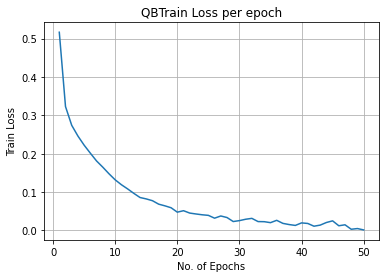

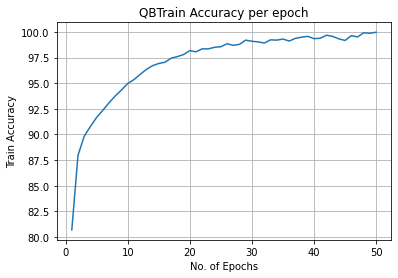

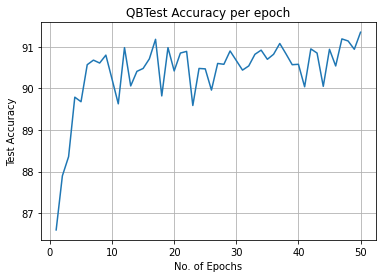

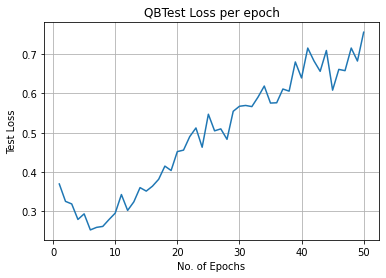

In [19]:
model_name='QB'
train_accuracy_list1,train_losses1,test_accuracy_list1,test_losses1=run_model(activation_func=nn.ReLU(),dp=False,lr=0.1,epochs=50)
plot_model(train_accuracy_list1,train_losses1,test_accuracy_list1,test_losses1,model_name)

In [7]:
train_accuracy_list2,train_losses2,test_accuracy_list2,test_losses2=run_model(activation_func=nn.Tanh(),dp=False,lr=0.1,epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): Tanh()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): Tanh()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): Tanh()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 83.01166534423828, Train Loss: 0.466300368309021
Test Accuracy: 87.3699951171875, Test Loss: 0.3560168445110321
2 epoch passed: Train Accuracy: 88.461669921875, Train Loss: 0.3171379864215851
Test Accuracy: 89.50999450683594, Test Loss: 0.29247987270355225
3 epoch passed: Train Accuracy: 90.14167022705078, Train Loss: 0.2658553421497345
Test Accuracy: 89.199996

In [8]:
train_accuracy_list3,train_losses3,test_accuracy_list3,test_losses3=run_model(activation_func=nn.Sigmoid(),dp=False,lr=0.1,epochs=50)

CNNmodel(
  (activation_func): Sigmoid()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): Sigmoid()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): Sigmoid()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


1 epoch passed: Train Accuracy: 9.845000267028809, Train Loss: 2.314316511154175
Test Accuracy: 10.0, Test Loss: 2.304154872894287
2 epoch passed: Train Accuracy: 9.983333587646484, Train Loss: 2.303865671157837
Test Accuracy: 10.0, Test Loss: 2.3044822216033936
3 epoch passed: Train Accuracy: 10.266666412353516, Train Loss: 2.3029286861419678
Test Accuracy: 10.0, Test Loss: 2.299882650375366
4 epoch passed: Train Accuracy: 39.77333450317383, Train Loss: 1.57795250415802
Test Accuracy: 67.55999755859375, Test Loss: 0.9054152965545654
5 epoch passed: Train Accuracy: 69.65666961669922, Train Loss: 0.793780505657196
Test Accuracy: 69.40999603271484, Test Loss: 0.7431922554969788
6 epoch passed: Train Accuracy: 73.73999786376953, Train Loss: 0.6727873682975769
Test Accuracy: 74.43000030517578, Test Loss: 0.6659706234931946
7 epoch passed: Train Accuracy: 75.87667083740234, Train Loss: 0.6153414845466614
Test Accuracy: 75.55999755859375, Test Loss: 0.6166888475418091
8 epoch passed: Train A

In [18]:
train_accuracy_list10,train_losses10,test_accuracy_list10,test_losses10=run_model(activation_func=nn.ELU(),dp=False,lr=0.1,epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ELU(alpha=1.0)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ELU(alpha=1.0)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ELU(alpha=1.0)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 83.33833312988281, Train Loss: 0.45702552795410156
Test Accuracy: 86.32999420166016, Test Loss: 0.37916553020477295
2 epoch passed: Train Accuracy: 88.27333068847656, Train Loss: 0.3165839612483978
Test Accuracy: 87.69999694824219, Test Loss: 0.3373257517814636
3 epoch passed: Train Accuracy: 89.98833465576172, Train Loss: 0.270265728235

In [10]:
train_accuracy_list4,train_losses4,test_accuracy_list4,test_losses4=run_model(activation_func=nn.ReLU(),dp=False,lr=0.001,epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 43.991668701171875, Train Loss: 1.913859248161316
Test Accuracy: 64.8699951171875, Test Loss: 1.0721426010131836
2 epoch passed: Train Accuracy: 68.83833312988281, Train Loss: 0.8641852736473083
Test Accuracy: 69.69999694824219, Test Loss: 0.7924171090126038
3 epoch passed: Train Accuracy: 72.55333709716797, Train Loss: 0.7300028204917908
Test Accuracy: 72.3600

In [11]:
train_accuracy_list5,train_losses5,test_accuracy_list5,test_losses5=run_model(activation_func=nn.ReLU(),dp=False,lr=0.5,epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 78.18167114257812, Train Loss: 0.5724900364875793
Test Accuracy: 83.41999816894531, Test Loss: 0.44586703181266785
2 epoch passed: Train Accuracy: 85.91666412353516, Train Loss: 0.3724844753742218
Test Accuracy: 86.63999938964844, Test Loss: 0.3472158908843994
3 epoch passed: Train Accuracy: 87.55999755859375, Train Loss: 0.3278298079967499
Test Accuracy: 86.59

KeyboardInterrupt: ignored

In [12]:
train_accuracy_list6,train_losses6,test_accuracy_list6,test_losses6=run_model(activation_func=nn.ReLU(),dp=False,lr=1,epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 9.96833324432373, Train Loss: 2.311732053756714
Test Accuracy: 10.0, Test Loss: 2.31292986869812
2 epoch passed: Train Accuracy: 10.126667022705078, Train Loss: 2.3097612857818604
Test Accuracy: 10.0, Test Loss: 2.3073370456695557
3 epoch passed: Train Accuracy: 9.970000267028809, Train Loss: 2.3095951080322266
Test Accuracy: 10.0, Test Loss: 2.3088221549987793

In [13]:
train_accuracy_list9,train_losses9,test_accuracy_list9,test_losses9=run_model(activation_func=nn.ReLU(),dp=False,lr=10,epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 10.001667022705078, Train Loss: nan
Test Accuracy: 10.0, Test Loss: nan
2 epoch passed: Train Accuracy: 10.0, Train Loss: nan
Test Accuracy: 10.0, Test Loss: nan
3 epoch passed: Train Accuracy: 10.0, Train Loss: nan
Test Accuracy: 10.0, Test Loss: nan
4 epoch passed: Train Accuracy: 10.0, Train Loss: nan
Test Accuracy: 10.0, Test Loss: nan
5 epoch passed: Train

CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


1 epoch passed: Train Accuracy: 79.41666412353516, Train Loss: 0.5537700057029724
Test Accuracy: 85.80999755859375, Test Loss: 0.38825762271881104
2 epoch passed: Train Accuracy: 87.55000305175781, Train Loss: 0.3384990990161896
Test Accuracy: 87.58999633789062, Test Loss: 0.35055604577064514
3 epoch passed: Train Accuracy: 89.43167114257812, Train Loss: 0.2887769937515259
Test Accuracy: 89.15999603271484, Test Loss: 0.30438023805618286
4 epoch passed: Train Accuracy: 90.42166900634766, Train Loss: 0.25812575221061707
Test Accuracy: 89.5999984741211, Test Loss: 0.2888757884502411
5 epoch passed: Train Accuracy: 91.41666412353516, Train Loss: 0.23077932000160217
Test Accuracy: 89.52999877929688, Test Loss: 0.30674365162849426
6 epoch passed: Train Accuracy: 92.09833526611328, Train Loss: 0.209255188703537
Test Accuracy: 90.72999572753906, Test Loss: 0.2612568736076355
7 epoch passed: Train Accuracy: 92.74833679199219, Train Loss: 0.19132666289806366
Test Accuracy: 90.56999969482422, Tes

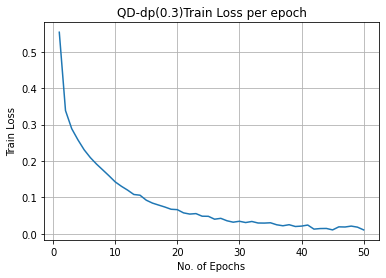

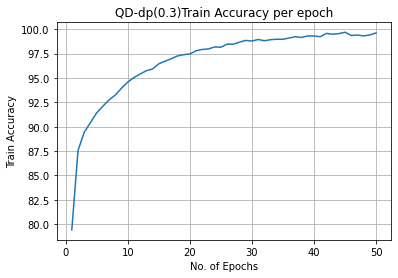

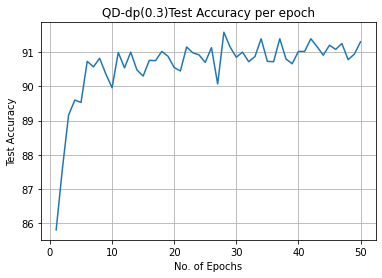

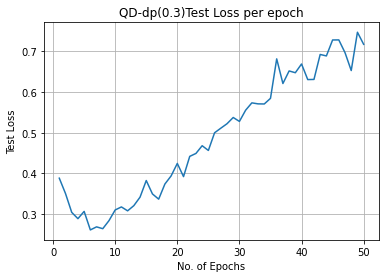

In [14]:
model_name='QD-dp(0.3)'
train_accuracy_list7,train_losses7,test_accuracy_list7,test_losses7=run_model(activation_func=nn.ReLU(),dp=0.3,lr=0.1,epochs=50)
plot_model(train_accuracy_list7,train_losses7,test_accuracy_list7,test_losses7,model_name)

In [ ]:
model_name='QD-dp(0.5)'
train_accuracy_list8,train_losses8,test_accuracy_list8,test_losses8=run_model(activation_func=nn.ReLU(),dp=0.5,lr=0.1,epochs=50)
plot_model(train_accuracy_list8,train_losses8,test_accuracy_list8,test_losses8,model_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 78.85166931152344, Train Loss: 0.5751940011978149
Test Accuracy: 85.25999450683594, Test Loss: 0.41937288641929626
2 epoch passed: Train Accuracy: 87.21833801269531, Train Loss: 0.3533228635787964
Test Accuracy: 86.0199966430664, Test Loss: 0.37170305848121643
3 epoch passed: Train Accuracy: 88.94667053222656, Train Loss: 0.3032267093658447
Test Accuracy: 88.40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNNmodel(
  (activation_func): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
1 epoch passed: Train Accuracy: 80.00167083740234, Train Loss: 0.5355303883552551
Test Accuracy: 85.31999969482422, Test Loss: 0.3820017874240875
2 epoch passed: Train Accuracy: 87.59333801269531, Train Loss: 0.3321661949157715
Test Accuracy: 87.97000122070312, Test Loss: 0.32111337780952454
3 epoch passed: Train Accuracy: 89.36499786376953, Train Loss: 0.28419506549835205
Test Accuracy: 89.2

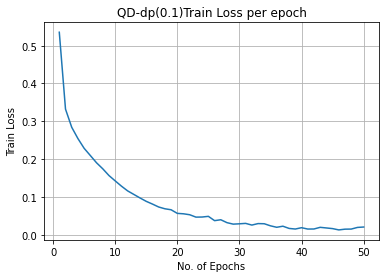

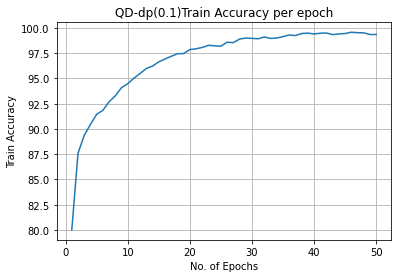

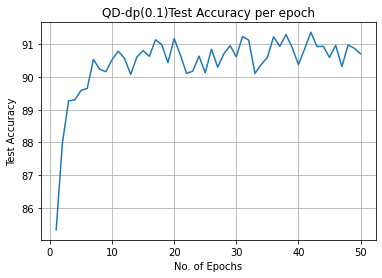

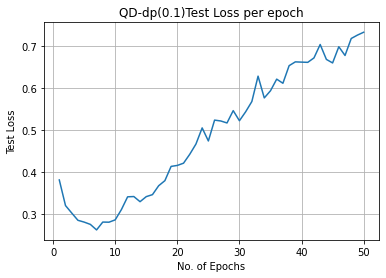

In [16]:
model_name='QD-dp(0.1)'
train_accuracy_list11,train_losses11,test_accuracy_list11,test_losses11=run_model(activation_func=nn.ReLU(),dp=0.1,lr=0.1,epochs=50)
plot_model(train_accuracy_list11,train_losses11,test_accuracy_list11,test_losses11,model_name)

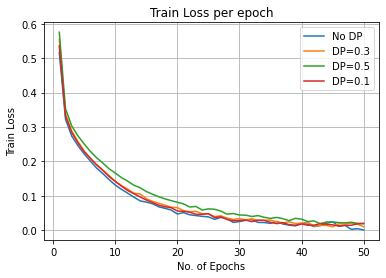

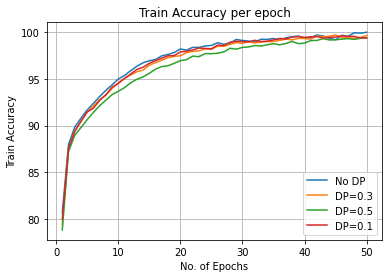

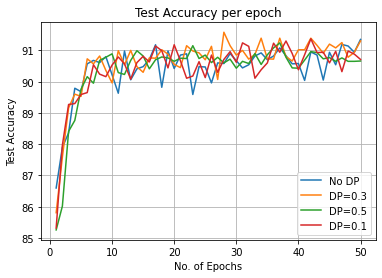

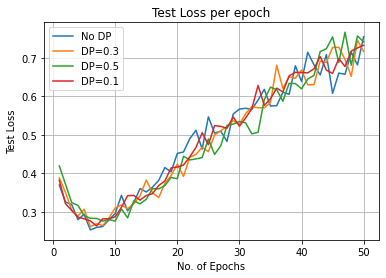

In [21]:
  plt.figure(1)
  plt.plot([i+1 for i in range(len(train_losses1))] ,train_losses1,label='No DP')
  plt.plot([i+1 for i in range(len(train_losses7))] ,train_losses7,label='DP=0.3')
  plt.plot([i+1 for i in range(len(train_losses8))] ,train_losses8,label='DP=0.5')
  plt.plot([i+1 for i in range(len(train_losses11))] ,train_losses11,label='DP=0.1')
  plt.xlabel("No. of Epochs")
  plt.ylabel("Train Loss")
  plt.title("Train Loss per epoch")
  plt.grid()
  plt.legend()
  plt.savefig("plots/Train Loss per epoch.jpg")
  plt.show()
  plt.figure(2)
  plt.plot([i+1 for i in range(len(train_accuracy_list1))] ,train_accuracy_list1,label='No DP')
  plt.plot([i+1 for i in range(len(train_accuracy_list7))] ,train_accuracy_list7,label='DP=0.3')
  plt.plot([i+1 for i in range(len(train_accuracy_list8))] ,train_accuracy_list8,label='DP=0.5')
  plt.plot([i+1 for i in range(len(train_accuracy_list11))] ,train_accuracy_list11,label='DP=0.1')
  plt.xlabel("No. of Epochs")
  plt.ylabel("Train Accuracy")
  plt.title("Train Accuracy per epoch")
  plt.grid()
  plt.legend()
  plt.savefig("plots/Train Accuracy per epoch.jpg")
  plt.show()
  plt.figure(3)
  plt.plot([i+1 for i in range(len(test_accuracy_list1))] ,test_accuracy_list1,label='No DP')
  plt.plot([i+1 for i in range(len(test_accuracy_list7))] ,test_accuracy_list7,label='DP=0.3')
  plt.plot([i+1 for i in range(len(test_accuracy_list8))] ,test_accuracy_list8,label='DP=0.5')
  plt.plot([i+1 for i in range(len(test_accuracy_list11))] ,test_accuracy_list11,label='DP=0.1')

  plt.xlabel("No. of Epochs")
  plt.ylabel("Test Accuracy")
  plt.title("Test Accuracy per epoch")
  plt.grid()
  plt.legend()
  plt.savefig("plots/Test Accuracy per epoch.jpg")
  plt.show()
  plt.figure(4)
  plt.plot([i+1 for i in range(len(test_losses1))] ,test_losses1,label='No DP')
  plt.plot([i+1 for i in range(len(test_losses7))] ,test_losses7,label='DP=0.3')
  plt.plot([i+1 for i in range(len(test_losses8))] ,test_losses8,label='DP=0.5')
  plt.plot([i+1 for i in range(len(test_losses11))] ,test_losses11,label='DP=0.1')
  plt.xlabel("No. of Epochs")
  plt.ylabel("Test Loss")
  plt.title("Test Loss per epoch")
  plt.grid()
  plt.legend()
  plt.savefig("plots/Test Loss per epoch.jpg")
  plt.show()

In [22]:
import shutil
shutil.make_archive('plots','zip','plots')

'/content/plots.zip'

In [25]:
for i in range(12):
  try:
    print(i,"   ",max(globals()["test_accuracy_list{}".format(i)]))
  except:
    pass

1     tensor(91.3500, device='cuda:0')
2     tensor(91.8600, device='cuda:0')
3     tensor(90.7600, device='cuda:0')
4     tensor(88.1200, device='cuda:0')
6     tensor(10., device='cuda:0')
7     tensor(91.5800, device='cuda:0')
8     tensor(91.2400, device='cuda:0')
9     tensor(10., device='cuda:0')
10     tensor(91.1300, device='cuda:0')
11     tensor(91.3700, device='cuda:0')
